In [1]:
# !pip install ipympl

In [2]:
%matplotlib widget
import matplotlib.pyplot as plt

In [3]:
from stpy.kernels import KernelFunction
from stpy.borel_set import BorelSet, HierarchicalBorelSets
from stpy.point_processes.poisson_rate_estimator import PoissonRateEstimator
import torch
import pandas as pd
import geopandas
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
from scipy.interpolate import griddata
from stpy.point_processes.poisson.poisson import PoissonPointProcess
from sensepy.capture_thompson import CaptureThompson
import time
from utils import *

2025-02-04 11:09:56.473078: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738663796.555367    2582 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738663796.581612    2582 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-04 11:09:56.748148: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import torch

numpy_dtype = np.float64
torch_dtype = torch.float64

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_device(device)
else:
    device = torch.device("cpu")
    torch.set_default_device(device)

torch.set_default_dtype(torch.float64)


print(f"Using device: {device}")

Using device: cuda


In [5]:
from stpy.kernels import KernelFunction
from stpy.borel_set import BorelSet

gamma = 0.2
kappa = 1.0
d = 2
dt = 30
kernel = KernelFunction(
    kernel_name="squared_exponential", gamma=gamma, kappa=kappa, d=d
)
m = 25
min_intensity = 0.0
max_intensity = 1e7
offset = 0.1
jitter = 1e-4
name = "sensepy/sensepy/benchmarks/data/taxi_data.csv"
Num_data_points = 50000 # Use all data
# borel set a square with boundaries [-1,1]^2
D = BorelSet(2, bounds=torch.tensor([[-1.0, 1.0], [-1, 1]]).to(torch_dtype))
obs, dt, gdf = get_taxi_data(Num_data_points, dtype=numpy_dtype)
obs = obs.to(device)
data = [(D, obs, dt)]
left, down, right, up = gdf.total_bounds

estimator = PoissonRateEstimator(
    HierarchicalBorelSets(d=2, interval=[(-1, 1), (-1, 1)], levels=8),
    d=d,
    kernel=kernel,
    max_intensity=max_intensity,
    min_intensity=min_intensity,
    basis_size_per_dim=m,
    langevine_sampling_steps=200,
    optimization_library="torch",
    use_anchors=False,
    basis="optimal-positive",
    samples_nystrom=500,
    roi=obs,
    memory_limit=1,
    device=device
)
estimator.load_data(data)
estimator.fit_gp()

Optimal basis with arbitrary dimension, namely d = 2
Starting optimal basis construction, with m = 25
Approximated data set with 5525 points for optimal basis.
Use GPU mode.
 niter=10, loss=10051.268887124916.
 niter=20, loss=9997.903223692589.
 niter=30, loss=9947.55312034567.
 niter=40, loss=9937.790808297921.
 niter=50, loss=9937.78790714109.
 niter=60, loss=9937.787739829922.
 niter=70, loss=9937.787720598355.
 niter=80, loss=9937.787718334946.
 niter=90, loss=9937.78771806472.
 niter=100, loss=9937.787718032348.
 niter=110, loss=9937.787718028465.
    Converged after 110 iteration(s).
Optimal basis constructed.
Precomputation finished.
nodes of functions torch.Size([25, 2])
CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH


In [6]:
# Example Data Generation Functions
from typing import Tuple

render_resolution = 100


# Simulated long-running data generation function.
def generate_data(
    xlim: Tuple[float, float], ylim: Tuple[float, float]
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    xmin, xmax = xlim
    ymin, ymax = ylim
    time.sleep(1.5)  # Simulate a slow computation.
    x = np.linspace(xmin, xmax, render_resolution)
    y = np.linspace(ymin, ymax, render_resolution)
    X, Y = np.meshgrid(x, y)
    Z = np.sin(X) * np.cos(Y)  # Example function
    return X, Y, Z


def plot_data(ax: plt.Axes, data: Tuple[np.ndarray, np.ndarray, np.ndarray]):
    X, Y, Z = data
    ax.contourf(X, Y, Z, cmap="viridis")
    ax.set_title("Zoom & Pan to Update Resolution (ipympl)")

In [7]:
# Set up dynamic data generation and plotting function
from typing import Tuple

render_resolution = 100
roi_resolution = 30
roi_num_basis_functions = 9

X, Y = np.meshgrid(
    np.linspace(left, right, render_resolution),
    np.linspace(down, up, render_resolution),
)


def clip_world(xlim, ylim):
    xmin, xmax = xlim
    ymin, ymax = ylim
    xmin = max(xmin, left)
    xmax = min(xmax, right)
    ymin = max(ymin, down)
    ymax = min(ymax, up)
    return ((xmin, xmax), (ymin, ymax))


def normalize_wold_limits(xlim, ylim):
    xmin, xmax = xlim
    ymin, ymax = ylim
    xmin_norm = 2 * (xmin - left) / (right - left) - 1
    xmax_norm = 2 * (xmax - left) / (right - left) -1
    ymin_norm = 2 * (ymin - down) / (up - down) -1
    ymax_norm = 2 * (ymax - down) / (up - down) -1
    return ((xmin_norm, xmax_norm), (ymin_norm, ymax_norm))


def generate_data(
    xlim_world: Tuple[float, float], ylim_world: Tuple[float, float]
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    xlim_clipped, ylim_clipped = clip_world(xlim_world, ylim_world)
    # CONVERT LIMITS
    xlim_model, ylim_model = normalize_wold_limits(xlim_clipped, ylim_clipped)
    xmin, xmax = xlim_model
    ymin, ymax = ylim_model

    # D.bounds gives bounds as a tensor [[xmin, xmax], [ymin, ymax]]
    x = torch.linspace(xmin, xmax, roi_resolution)
    y = torch.linspace(ymin, ymax, roi_resolution)
    x, y = torch.meshgrid(x, y, indexing='ij')
    roi_base = torch.stack([x.flatten(), y.flatten()], dim=-1).to(device)
    # RECALCULATE BASIS
    estimator.packing.add_new_functions(roi_base, roi_num_basis_functions)
    estimator.m = estimator.packing.m
    estimator.load_data(data)
    estimator.fit_gp()

    # GET RATE
    x = torch.linspace(xmin, xmax, render_resolution)
    y = torch.linspace(ymin, ymax, render_resolution)
    x, y = torch.meshgrid(x, y, indexing="ij")
    roi_render = torch.stack([x.flatten(), y.flatten()], dim=-1).to(device)
    Z = estimator.rate_value(roi_render).reshape(render_resolution, render_resolution)

    # GET WORLD COORDINATES
    X, Y = np.meshgrid(
        np.linspace(xlim_clipped[0], xlim_clipped[1], render_resolution),
        np.linspace(ylim_clipped[0], ylim_clipped[1], render_resolution),
        indexing="ij",
    )

    return xlim_world, ylim_world, X, Y, Z.cpu().numpy() #, gdf.clip((left, down, right, up))


def plot_data(ax: plt.Axes, data: Tuple[np.ndarray, np.ndarray, np.ndarray]):
    xlim_world, ylim_world, X, Y, Z = data
    # geopandas.GeoDataFrame
    gdf.plot(ax=ax, color="red", markersize=0.5)
    cs = ax.contourf(X, Y, Z, cmap="viridis", levels=20, alpha=0.5)
    # ax.contour(cs, colors="k", alpha=0.5)
    ax.set_title("Zoom & Pan to Update Resolution (ipympl)")
    # ctx.add_basemap(ax, crs=gdf.crs.to_string())
    ax.set_xlim(*xlim_world)
    ax.set_ylim(*ylim_world)

Use GPU mode.
 niter=10, loss=607998.8839201675.
 niter=20, loss=603492.3206174126.
 niter=30, loss=602302.398456983.
 niter=40, loss=602294.5082751325.
 niter=50, loss=602283.3128421708.
 niter=60, loss=602245.6739567246.
 niter=70, loss=601967.1407122272.
 niter=80, loss=595924.4549917526.
 niter=90, loss=595908.3182837373.
 niter=100, loss=595908.3132492446.
    Converged after 100 iteration(s).
nodes of functions torch.Size([34, 2])
CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH


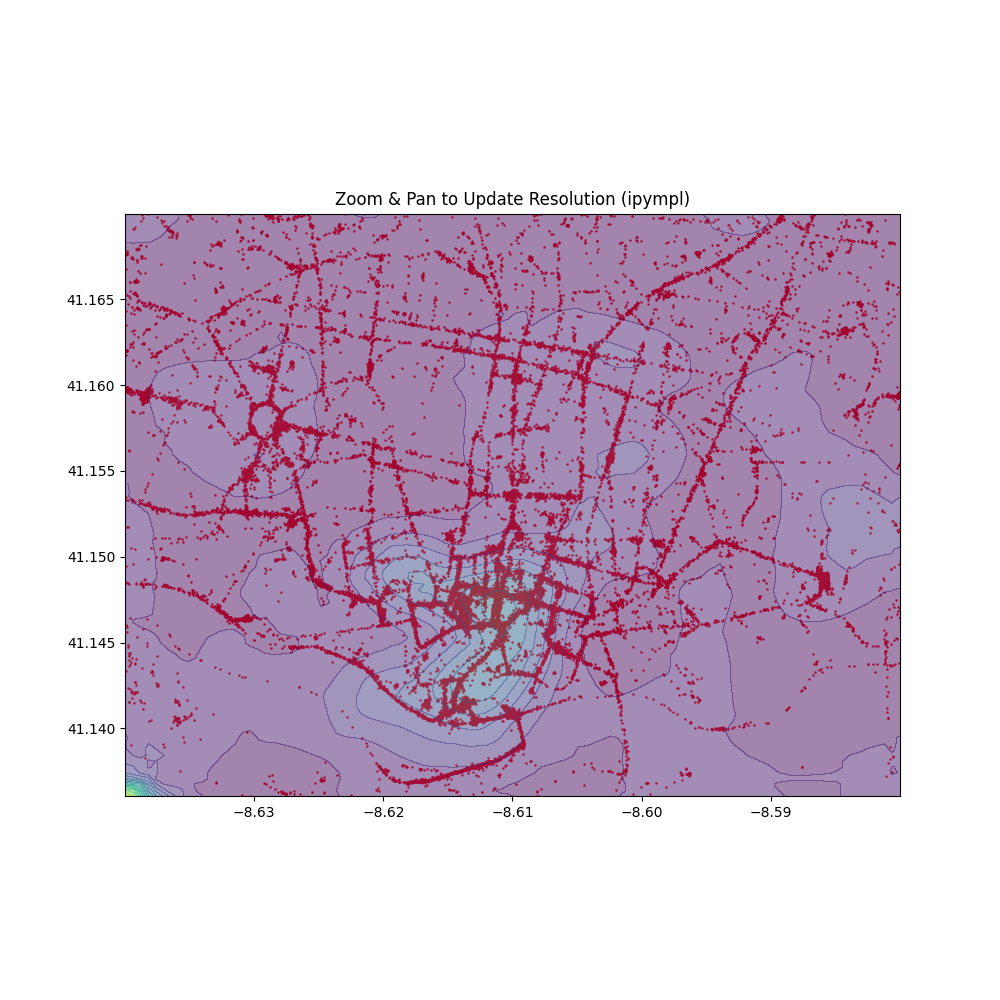

Use GPU mode.
 niter=10, loss=520413.49272795115.
 niter=20, loss=520194.3633082909.
 niter=30, loss=520148.52418515563.
 niter=40, loss=520136.7048772178.
 niter=50, loss=520133.7190548705.
 niter=60, loss=520132.9736699622.
 niter=70, loss=520132.78856907634.
 niter=80, loss=520132.7426476704.
    Converged after 80 iteration(s).
nodes of functions torch.Size([34, 2])
CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
Use GPU mode.
 niter=10, loss=566286.0406740498.
 niter=20, loss=565896.3423707124.
 niter=30, loss=565861.6115873434.
 niter=40, loss=565852.6502006568.
 niter=50, loss=565850.314599416.
 niter=60, loss=565849.7027456337.
 niter=70, loss=565849.5430052209.
 niter=80, loss=565849.5013727434.
    Converged after 80 iteration(s).
nodes of functions torch.Size([34, 2])
CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
Use GPU mode.
 niter=10, loss=466881.1853663301.
 niter=20, loss=465496.6206695391.
 niter=30, loss=462942.67575703864.
 niter=40, loss=460101.132779581

In [9]:
import threading
import asyncio
import queue

# Generate initial data.
data0 = generate_data(
    (left, right), (down, up)
)

# Create the figure and contour plot.
fig, ax = plt.subplots(figsize=(10, 10))
plot_data(ax, data0)

# Shared queue to store updated data.
data_queue = queue.Queue()
# Variable to store the current thread handle.
current_thread = None

def update_plot_thread(xlim, ylim):
    if torch.cuda.is_available():
        device = torch.device("cuda")
        torch.set_default_device(device)
    else:
        device = torch.device("cpu")
        torch.set_default_device(device)
    data = generate_data(xlim, ylim)
    data_queue.put(data)

first_move_time = None

def on_limits_changed(event_axis):
    global current_thread, prev_xlim, prev_ylim, first_move_time

    current_xlim = event_axis.get_xlim()
    current_ylim = event_axis.get_ylim()

    eps_x = (prev_xlim[1] - prev_xlim[0]) / 100
    eps_y = (prev_ylim[1] - prev_ylim[0]) / 100

    if np.any(np.abs(np.array(current_xlim) - np.array(prev_xlim)) > eps_x) or np.any(
        np.abs(np.array(current_ylim) - np.array(prev_ylim)) > eps_y
    ):

        if first_move_time is None:
            first_move_time = time.time()
            return
        elif time.time() - first_move_time < 0.2:
            return

        if current_thread and current_thread.is_alive():
            return  # A thread is already running, do nothing
        current_xlim = event_axis.get_xlim()
        current_ylim = event_axis.get_ylim()

        prev_xlim = current_xlim
        prev_ylim = current_ylim

        ax.text(
            0.5,
            0.5,
            "Loading...",
            fontsize=20,
            color="white",
            ha="center",
            va="center",
            transform=ax.transAxes,
            bbox=dict(facecolor="black", alpha=0.7, boxstyle="round,pad=0.5"),
            visible=True,
        )
        fig.canvas.draw_idle()

        current_thread = threading.Thread(
            target=update_plot_thread, args=(current_xlim, current_ylim)
        )
        current_thread.start()


async def poll_for_updates():
    global prev_xlim, prev_ylim, first_move_time
    while True:
        await asyncio.sleep(0.1)
        if not data_queue.empty():
            data = data_queue.get()
            ax.clear()
            plot_data(ax, data)
            ax.callbacks.connect("xlim_changed", on_limits_changed)
            ax.callbacks.connect("ylim_changed", on_limits_changed)
            first_move_time = None
            fig.canvas.draw_idle()


# Start the asyncio task for polling.
asyncio.create_task(poll_for_updates())

prev_xlim, prev_ylim = ax.get_xlim(), ax.get_ylim()
ax.callbacks.connect("xlim_changed", on_limits_changed)
ax.callbacks.connect("ylim_changed", on_limits_changed)

plt.show()